Name: Apoorva Panchal
<br>
Github Username: ApoorvaPanchal
<br>
USC ID: 8685016290   


In [1]:
import os
import os.path as op
from pathlib import Path
import logging
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import warnings 
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, Dropout, BatchNormalization, Activation, RandomContrast, RandomCrop, RandomFlip, RandomZoom, RandomTranslation, RandomRotation, GlobalMaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import EfficientNetB0, ResNet50, VGG16
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings('ignore')

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
# Logging configuration
# logging.basicConfig(level=logging.INFO,
#                     datefmt='%H:%M:%S',
#                     format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
# IMAGE_SIZE = (75,75)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [4]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./train_source_images.txt')
validate_ids = load_text_ids('./val_source_images.txt')
test_ids = load_text_ids('./test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

# Loading and pre processing the data
### Note that there are multiple ways to preprocess and load your data in order to train your model in tensorflow. We have provided one way to do it in the following cell. Feel free to use your own method and get better results.

In [5]:
import random
from PIL import Image 

def load_and_preprocess(img_loc, label):
    
    def _inner_function(img_loc, label):
        
        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')

        # Load image using PIL and convert to RGB
        img = Image.open(img_loc_str).convert('RGB')

        # Convert PIL image to numpy array
        img = np.array(img)
        img = tf.image.resize(img, [299, 299])
        # img = tf.image.resize(img, [75, 75])

        # Normalize the image to the [0, 1] range
        img = img / 255.0

        # Convert label to integer (assuming binary classification)
        label = 1 if label.numpy().decode('utf-8') == 'frost' else 0
        return img, label

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])

    # Set the shape of the tensors
    X.set_shape([299, 299, 3])
    # X.set_shape([75, 75, 3])
    y.set_shape([]) # Scalar label
    return X, y

def load_subdir_data(dir_path, image_size, seed=None):
    
    """Helper to create a TF dataset from each image subdirectory"""
    
    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')
    
    loc_list = []
    
    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
        
one_hot_encoder = OneHotEncoder(sparse=False)

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size) 

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size) 

# C. Training CNN + MLP

i. Emperical Regularization

(299, 299, 3)

In [6]:
tf_dataset_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [7]:
model_cnn = Sequential()

model_cnn.add(RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'))
model_cnn.add(RandomFlip(mode='horizontal_and_vertical'))
model_cnn.add(RandomRotation(factor=(-0.2, 0.2), fill_mode='nearest', interpolation='bilinear'))
model_cnn.add(RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'))
model_cnn.add(RandomContrast(0.2))

model_cnn.add(Conv2D(32, kernel_size=(3,3), input_shape=(299,299,3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(64, kernel_size=(3,3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Conv2D(128, kernel_size=(3,3), padding='same'))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))
model_cnn.add(MaxPooling2D((2, 2)))

model_cnn.add(Flatten())
model_cnn.add(Dense(256, kernel_regularizer=l2(0.1)))
model_cnn.add(Activation('relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.3))

model_cnn.add(Dense(2, activation='softmax'))

model_cnn.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_cnn.build(input_shape=(None, 299, 299, 3))
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_zoom (RandomZoom)    (None, 299, 299, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 299, 299, 3)       0         
                                                                 
 random_rotation (RandomRot  (None, 299, 299, 3)       0         
 ation)                                                          
                                                                 
 random_translation (Random  (None, 299, 299, 3)       0         
 Translation)                                                    
                                                                 
 random_contrast (RandomCon  (None, 299, 299, 3)       0         
 trast)                                                          
                                                        

In [8]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, start_from_epoch=10)
history_cnn = model_cnn.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=early_stopping)
model_cnn.evaluate(tf_dataset_test)

Epoch 1/20
928/928 [==============================] - 449s 474ms/step - loss: 2.5900 - accuracy: 0.6860 - val_loss: 1.8697 - val_accuracy: 0.3934
Epoch 2/20
928/928 [==============================] - 432s 465ms/step - loss: 1.5932 - accuracy: 0.7467 - val_loss: 1.7772 - val_accuracy: 0.5688
Epoch 3/20
928/928 [==============================] - 432s 465ms/step - loss: 1.3309 - accuracy: 0.7848 - val_loss: 1.8965 - val_accuracy: 0.4406
Epoch 4/20
928/928 [==============================] - 432s 464ms/step - loss: 1.2128 - accuracy: 0.8024 - val_loss: 1.5073 - val_accuracy: 0.7010
Epoch 5/20
928/928 [==============================] - 429s 462ms/step - loss: 1.1710 - accuracy: 0.8218 - val_loss: 2.6360 - val_accuracy: 0.6114
Epoch 6/20
928/928 [==============================] - 432s 465ms/step - loss: 1.0715 - accuracy: 0.8349 - val_loss: 2.6790 - val_accuracy: 0.4674
Epoch 7/20
928/928 [==============================] - 425s 457ms/step - loss: 1.1693 - accuracy: 0.8387 - val_loss: 1.1873 -

[1.4375579357147217, 0.8115885257720947]

In [9]:
results_cnn = model_cnn.evaluate(tf_dataset_test)

401/401 [==============================] - 62s 153ms/step - loss: 1.4376 - accuracy: 0.8116


In [10]:
predictions_cnn = model_cnn.predict(tf_dataset_test)
class_predictions_cnn = predictions_cnn.argmax(axis=-1)

401/401 [==============================] - 45s 109ms/step


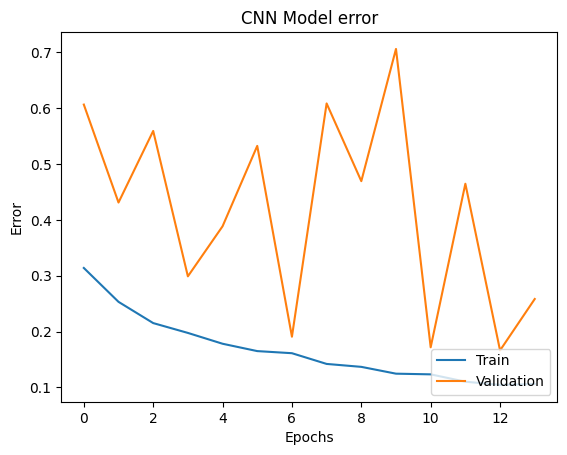

In [11]:
plt.plot(1 - np.array(history_cnn.history['accuracy']))
plt.plot(1 - np.array(history_cnn.history['val_accuracy']))
plt.title('CNN Model error')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [12]:
y_test = np.concatenate([y for _, y in tf_dataset_test], axis=0)
print(classification_report(y_test, class_predictions_cnn))

              precision    recall  f1-score   support

           0       0.35      0.32      0.33      4418
           1       0.66      0.68      0.67      8405

    accuracy                           0.56     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.56      0.55     12823



# D. Transfer Learning

EfficientNetB0,
ResNet50, and VGG16

### Augmented Data layers

In [13]:
inputs = Input(shape=(299, 299, 3))

img_aug = Sequential()
img_aug.add(RandomZoom(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'))
img_aug.add(RandomFlip(mode='horizontal_and_vertical'))
img_aug.add(RandomRotation(factor=(-0.2, 0.2), fill_mode='nearest', interpolation='bilinear'))
img_aug.add(RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), fill_mode='nearest'))
img_aug.add(RandomContrast(0.2))

aug_data = img_aug(inputs)


### Transfer Learning :  Efficient Net B0 Model

In [14]:
efficient_net = EfficientNetB0(include_top=False, weights="imagenet", input_shape=(299, 299, 3), input_tensor=aug_data)

for layer in efficient_net.layers:
    layer.trainable = False

x = GlobalAveragePooling2D(name = "avg_pool")(efficient_net.output)
x = Dense(256)(x) 
x = Activation("relu")(x)
x = BatchNormalization()(x)
y = Dropout(0.3)(x)    
output = Dense(2, activation = "softmax")(y)

model_efficient_net = Model(inputs=efficient_net.input, outputs=output)

model_efficient_net.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_efficient_net.build(input_shape=(None, 299, 299, 3))
model_efficient_net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 rescaling (Rescaling)       (None, 299, 299, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 normalization (Normalizati  (None, 299, 299, 3)          7         ['rescaling[0][0]']           
 on)                                                                                          

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, start_from_epoch=8)
history_efficient_net = model_efficient_net.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=early_stopping, batch_size=8)
model_efficient_net.evaluate(tf_dataset_test)

Epoch 1/20
928/928 [==============================] - 376s 384ms/step - loss: 0.6844 - accuracy: 0.5795 - val_loss: 0.6722 - val_accuracy: 0.6710
Epoch 2/20
928/928 [==============================] - 316s 341ms/step - loss: 0.6701 - accuracy: 0.5778 - val_loss: 0.6777 - val_accuracy: 0.6254
Epoch 3/20
928/928 [==============================] - 314s 338ms/step - loss: 0.6689 - accuracy: 0.5795 - val_loss: 0.7962 - val_accuracy: 0.2912
Epoch 4/20
928/928 [==============================] - 313s 337ms/step - loss: 0.6670 - accuracy: 0.5789 - val_loss: 0.6625 - val_accuracy: 0.6783
Epoch 5/20
928/928 [==============================] - 313s 337ms/step - loss: 0.6658 - accuracy: 0.5774 - val_loss: 0.6475 - val_accuracy: 0.7282
Epoch 6/20
928/928 [==============================] - 314s 338ms/step - loss: 0.6669 - accuracy: 0.5742 - val_loss: 0.6741 - val_accuracy: 0.6310
Epoch 7/20
928/928 [==============================] - 313s 337ms/step - loss: 0.6669 - accuracy: 0.5785 - val_loss: 0.6737 -

[0.6916972398757935, 0.5578258037567139]

In [16]:
results_efficient_net = model_efficient_net.evaluate(tf_dataset_test)

401/401 [==============================] - 81s 202ms/step - loss: 0.6917 - accuracy: 0.5578


In [21]:
predictions_efficient_net = model_efficient_net.predict(tf_dataset_test)
class_predictions_efficient_net = predictions_efficient_net.argmax(axis=-1)

401/401 [==============================] - 115s 249ms/step


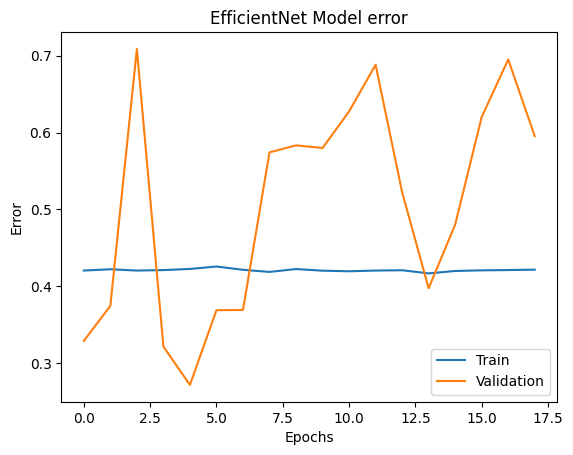

In [22]:
plt.plot(1 - np.array(history_efficient_net.history['accuracy']))
plt.plot(1 - np.array(history_efficient_net.history['val_accuracy']))
plt.title('EfficientNet Model error')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [29]:
y_test = np.concatenate([y for _, y in tf_dataset_test], axis=0)
print(classification_report(y_test, class_predictions_efficient_net))

              precision    recall  f1-score   support

           0       0.34      0.52      0.41      4418
           1       0.65      0.47      0.55      8405

    accuracy                           0.49     12823
   macro avg       0.49      0.49      0.48     12823
weighted avg       0.54      0.49      0.50     12823



### Transfer Learning : Resnet50 Model

In [17]:
resnet = ResNet50(include_top=False, weights="imagenet", input_shape=(75, 75, 3), input_tensor=aug_data)
for layer in resnet.layers:
    layer.trainable = False

x = GlobalAveragePooling2D(name = "avg_pool")(resnet.output)
x = Dense(256)(x) 
x = Activation("relu")(x)
x = BatchNormalization()(x)
y = Dropout(0.3)(x)    
output = Dense(2, activation = "softmax")(y)

model_resnet = Model(inputs=resnet.input, outputs=output)

model_resnet.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_resnet.build(input_shape=(None, 299, 299, 3))
model_resnet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 sequential_1 (Sequential)   (None, 299, 299, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 305, 305, 3)          0         ['sequential_1[0][0]']        
                                                                                                  
 conv1_conv (Conv2D)         (None, 150, 150, 64)         9472      ['conv1_pad[0][0]']           
                                                                                            

In [18]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, start_from_epoch=8)
history_resnet = model_resnet.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=early_stopping, batch_size=8)
results_resnet = model_resnet.evaluate(tf_dataset_test)

Epoch 1/20
928/928 [==============================] - 459s 480ms/step - loss: 0.5367 - accuracy: 0.7316 - val_loss: 12.8355 - val_accuracy: 0.3218
Epoch 2/20
928/928 [==============================] - 425s 458ms/step - loss: 0.5029 - accuracy: 0.7569 - val_loss: 0.4931 - val_accuracy: 0.7411
Epoch 3/20
928/928 [==============================] - 424s 456ms/step - loss: 0.4950 - accuracy: 0.7622 - val_loss: 2.4292 - val_accuracy: 0.3238
Epoch 4/20
928/928 [==============================] - 424s 457ms/step - loss: 0.4900 - accuracy: 0.7631 - val_loss: 15.0587 - val_accuracy: 0.3218
Epoch 5/20
928/928 [==============================] - 425s 458ms/step - loss: 0.4837 - accuracy: 0.7711 - val_loss: 5.5225 - val_accuracy: 0.3218
Epoch 6/20
928/928 [==============================] - 424s 457ms/step - loss: 0.4842 - accuracy: 0.7701 - val_loss: 7.4665 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 424s 457ms/step - loss: 0.4802 - accuracy: 0.7747 - val_loss: 0.1828

Accuracy : 85.28

In [26]:
predictions_resnet = model_resnet.predict(tf_dataset_test)
class_predictions_resnet = predictions_resnet.argmax(axis=-1)

401/401 [==============================] - 131s 309ms/step


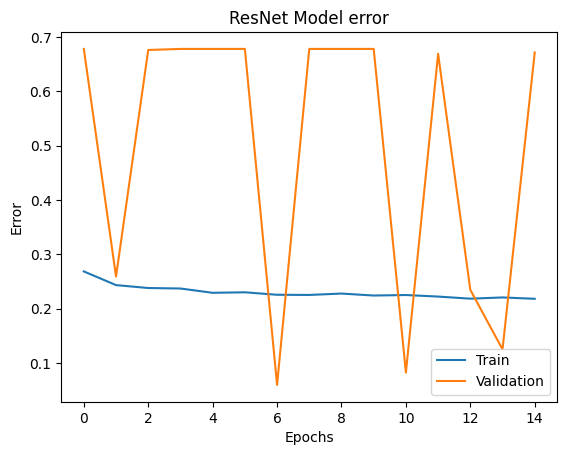

In [27]:
plt.plot(1 - np.array(history_resnet.history['accuracy']))
plt.plot(1 - np.array(history_resnet.history['val_accuracy']))
plt.title('ResNet Model error')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [28]:
y_test = np.concatenate([y for _, y in tf_dataset_test], axis=0)
print(classification_report(y_test, class_predictions_resnet))

              precision    recall  f1-score   support

           0       0.34      0.38      0.36      4418
           1       0.65      0.62      0.63      8405

    accuracy                           0.53     12823
   macro avg       0.50      0.50      0.50     12823
weighted avg       0.55      0.53      0.54     12823



### Transfer Learning : VGG16 Model

In [19]:
# inputs = layers.Input(shape=(75, 75, 3))
vgg16 = VGG16(include_top=False, weights="imagenet", input_shape=(299, 299, 3), input_tensor=aug_data)
for layer in vgg16.layers:
    layer.trainable = False

x = GlobalAveragePooling2D(name = "avg_pool")(vgg16.output)
x = Dense(256)(x) 
x = Activation("relu")(x)
x = BatchNormalization()(x)
y = Dropout(0.3)(x)    
output = Dense(2, activation = "softmax")(y)

model_vgg16 = Model(inputs=vgg16.input, outputs=output)

model_vgg16.compile(optimizer=Adam(learning_rate=0.0005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_vgg16.build(input_shape=(None, 299, 299, 3))
model_vgg16.summary()


58889256/58889256 [==============================] - 8s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 299, 299, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                            

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, start_from_epoch=8)
history_vgg16 = model_vgg16.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=early_stopping, batch_size=8)
results_vgg16 = model_vgg16.evaluate(tf_dataset_test)

Epoch 1/20
928/928 [==============================] - 638s 678ms/step - loss: 0.4622 - accuracy: 0.7787 - val_loss: 0.6976 - val_accuracy: 0.7071
Epoch 2/20
928/928 [==============================] - 662s 713ms/step - loss: 0.3939 - accuracy: 0.8160 - val_loss: 0.7319 - val_accuracy: 0.6832
Epoch 3/20
928/928 [==============================] - 620s 668ms/step - loss: 0.3790 - accuracy: 0.8230 - val_loss: 0.5171 - val_accuracy: 0.7961
Epoch 4/20
928/928 [==============================] - 620s 668ms/step - loss: 0.3700 - accuracy: 0.8278 - val_loss: 0.3356 - val_accuracy: 0.8621
Epoch 5/20
928/928 [==============================] - 625s 673ms/step - loss: 0.3649 - accuracy: 0.8330 - val_loss: 0.4184 - val_accuracy: 0.8215
Epoch 6/20
928/928 [==============================] - 622s 671ms/step - loss: 0.3634 - accuracy: 0.8342 - val_loss: 0.4849 - val_accuracy: 0.8068
Epoch 7/20
928/928 [==============================] - 628s 677ms/step - loss: 0.3601 - accuracy: 0.8348 - val_loss: 0.5350 -

Accuracy VGG16: 86.75

In [23]:
predictions_vgg16 = model_vgg16.predict(tf_dataset_test)
class_predictions_vgg16 = predictions_vgg16.argmax(axis=-1)

401/401 [==============================] - 186s 458ms/step


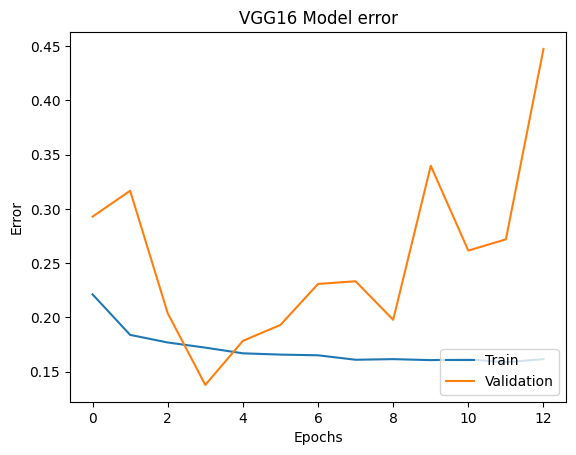

In [24]:
plt.plot(1 - np.array(history_vgg16.history['accuracy']))
plt.plot(1 - np.array(history_vgg16.history['val_accuracy']))
plt.title('VGG16 Model error')
plt.ylabel('Error')
plt.xlabel('Epochs')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [25]:
y_test = np.concatenate([y for _, y in tf_dataset_test], axis=0)
print(classification_report(y_test, class_predictions_vgg16))

              precision    recall  f1-score   support

           0       0.36      0.36      0.36      4418
           1       0.66      0.66      0.66      8405

    accuracy                           0.55     12823
   macro avg       0.51      0.51      0.51     12823
weighted avg       0.56      0.55      0.55     12823



| Model | Accuracy |  
| :- | :-: |  
| CNN + MLP | 0.8116 |  
| EffiecientNetB0 | 0.5578 |  
| ResNet50 | 0.8528 | 
| VGG16 | 0.8675 | 

As we can observe from the above table, the accuracy for the VGG16 model is the highest with the transfer learning. 